In [1]:
pwd

'/Users/jamahusseinmohamud/Desktop/research/DM research/large_scale_correlations/large_scale_task_correlation/notebooks'

In [2]:
%cd ..

/Users/jamahusseinmohamud/Desktop/research/DM research/large_scale_correlations/large_scale_task_correlation


In [50]:
import torch
import math
import csv
import torchvision
from torchvision import transforms
from PIL import Image
from src.models.architectures import ResNet18
import multiprocessing
from sklearn.cluster import KMeans
from collections import defaultdict
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
from graph_tool.all import *
from graph_tool.draw import graph_draw
from sklearn.cluster import SpectralCoclustering
import graph_tool.all as gt
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import accuracy_score, f1_score, average_precision_score

In [51]:
seed = 3971
torch.random.seed()
np.random.seed(seed=seed)

In [6]:
data_path = '/Users/jamahusseinmohamud/Desktop/research/DM research/large_scale_correlations/large_scale_task_correlation/data/celeb_datasets'
celebData = torchvision.datasets.CelebA(data_path, split='all', target_type = 'attr', transform=transforms.ToTensor(), download = True)
celebData.attr_names.remove('')
print(celebData.attr_names)

Files already downloaded and verified
['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [9]:
num_workers = multiprocessing.cpu_count()
trainloader = torch.utils.data.DataLoader(
    celebData, batch_size=4, shuffle=True, num_workers=num_workers)


In [10]:
batch = next(iter(trainloader))
batch[1]

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
         1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]])

In [18]:

multilabel_matrix = torch.zeros((len(celebData), len(celebData.attr_names)))
i = 0
batch_size = 4
for image, labels in trainloader:
    multilabel_matrix[i:i+batch_size] = labels
    i += batch_size

# multilabel_matrix[4:4+batch_size]

In [19]:
len(celebData)

202599

In [21]:
correlation_matrix = np.corrcoef(np.array(multilabel_matrix), rowvar = False)
corr_df = pd.DataFrame(correlation_matrix)
corr_df.columns = celebData.attr_names
correlation_matrix.shape

(40, 40)

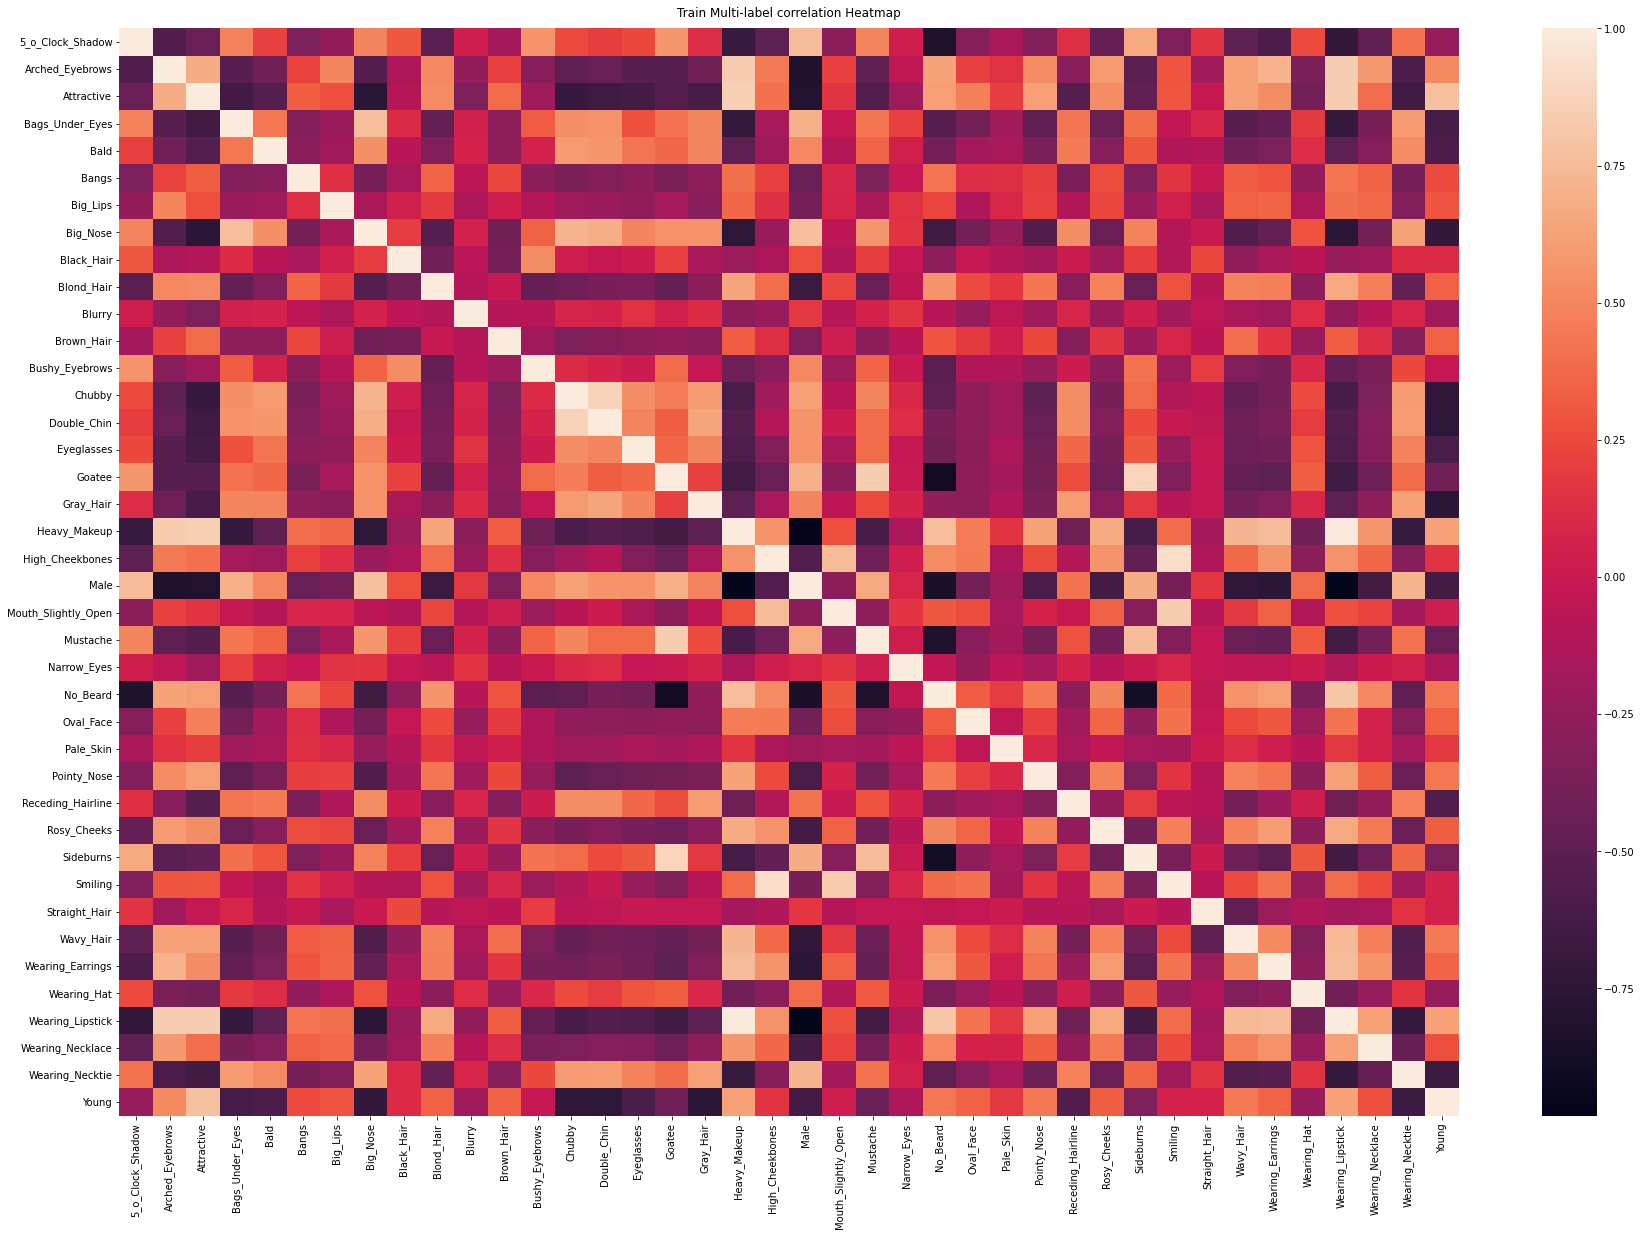

In [23]:
# Increase the size of the heatmap.
plt.figure(figsize=(30, 20))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(corr_df.corr(), annot=False)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Train Multi-label correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

In [24]:


# Assume 'correlation_matrix' is your 40x40 matrix

# Create an empty undirected Graph
g = Graph(directed=False)

# Add vertices to the graph
vlist = g.add_vertex(correlation_matrix.shape[0])

# Create an edge property map for the weights
weight = g.new_edge_property("double")

# Loop over the correlation matrix and add edges with weights
for i in range(correlation_matrix.shape[0]):
    for j in range(i+1, correlation_matrix.shape[1]):
        e = g.add_edge(g.vertex(i), g.vertex(j))
        weight[e] = correlation_matrix[i, j]  # set the weight of the edge

# Save the edge property map to the graph
g.ep['weight'] = weight


In [32]:


# Normalize the weights to the range [0, 1] for visualization
weight.a = (weight.a - weight.a.min()) / (weight.a.max() - weight.a.min())

graph_draw(g, edge_color=weight, output="cm_graph.png")


<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28bb4b790, at 0x29fa1f4f0>

### Spectral clustering visualization

In [37]:


def update_graph(g):
    # Create a networkx graph from the adjacency matrix
    # Get the edge weights as a property map
    edge_weights = g.ep["weight"]
    # Convert graph-tool graph to adjacency matrix, considering the weights
    adj_matrix = gt.adjacency(g, weight=edge_weights).toarray()
    # np.fill_diagonal(adj_matrix, 1)

    G = nx.from_numpy_array(adj_matrix)
    return G


In [33]:

# Initialize the model
model = SpectralCoclustering(n_clusters=4, random_state=0)

# Fit the model and predict cluster labels
model.fit(correlation_matrix)

# Get row and column labels
row_labels = model.row_labels_
col_labels = model.column_labels_
assert (row_labels == col_labels).all()

In [45]:
col_labels

array([3, 2, 1, 0, 0, 1, 1, 0, 3, 2, 1, 1, 3, 0, 0, 0, 3, 0, 2, 2, 3, 2,
       3, 1, 2, 1, 1, 1, 0, 2, 3, 2, 1, 1, 2, 1, 2, 2, 0, 1], dtype=int32)

In [34]:
def create_cluster_layout(G, labels):
    # Create a layout for each cluster
    pos = defaultdict(dict)
    offsets = {0: np.array([2, 2]),
               1: np.array([-2, 2]),
               2: np.array([-2, 5]),
               3: np.array([2, 5])}
    for label in set(labels):
        subgraph_nodes = [node for node in G.nodes if labels[node] == label]
        subgraph = G.subgraph(subgraph_nodes)
        subgraph_pos = nx.spring_layout(subgraph)
        pos[label] = subgraph_pos

    # Combine the layouts -- with a distinct offset to separate clusters
    combined_pos = dict()
    for label in pos:
        offset = offsets[label]
        for node in pos[label]:
            combined_pos[node] = pos[label][node] + offset

    return combined_pos

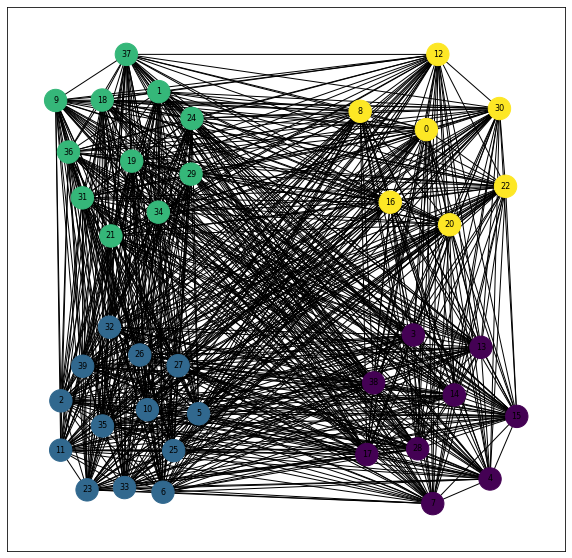

In [48]:

G = update_graph(g)
# Create a layout for the graph
pos = create_cluster_layout(G, labels=row_labels)
# Create a new figure
plt.figure(figsize=(10,10))
# Draw the graph using the layout
nx.draw_networkx(G, pos, node_color=col_labels, with_labels=True, node_size=500, font_size=8)
plt.savefig("spectral_clustering_viz.pdf", bbox_inches="tight")
plt.show()

array([3, 2, 1, 0, 0, 1, 1, 0, 3, 2, 1, 1, 3, 0, 0, 0, 3, 0, 2, 2, 3, 2,
       3, 1, 2, 1, 1, 1, 0, 2, 3, 2, 1, 1, 2, 1, 2, 2, 0, 1], dtype=int32)

In [56]:

def get_cluster_map(labels, label_names):
    cluster_label_to_name_map_spec = defaultdict(list)

    for i, cl_label in enumerate(labels):
        cluster_label_to_name_map_spec[str(cl_label)].append(label_names[i])
    return cluster_label_to_name_map_spec

get_cluster_map(labels=row_labels, label_names=celebData.attr_names)

defaultdict(list,
            {'3': ['5_o_Clock_Shadow',
              'Black_Hair',
              'Bushy_Eyebrows',
              'Goatee',
              'Male',
              'Mustache',
              'Sideburns'],
             '2': ['Arched_Eyebrows',
              'Blond_Hair',
              'Heavy_Makeup',
              'High_Cheekbones',
              'Mouth_Slightly_Open',
              'No_Beard',
              'Rosy_Cheeks',
              'Smiling',
              'Wearing_Earrings',
              'Wearing_Lipstick',
              'Wearing_Necklace'],
             '1': ['Attractive',
              'Bangs',
              'Big_Lips',
              'Blurry',
              'Brown_Hair',
              'Narrow_Eyes',
              'Oval_Face',
              'Pale_Skin',
              'Pointy_Nose',
              'Straight_Hair',
              'Wavy_Hair',
              'Wearing_Hat',
              'Young'],
             '0': ['Bags_Under_Eyes',
              'Bald',
              'Bi

### Kmeans clustering Visualization

In [52]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0).fit(correlation_matrix)
kmeans.labels_


array([3, 1, 1, 2, 2, 0, 0, 2, 0, 1, 0, 0, 3, 2, 2, 2, 3, 2, 1, 1, 3, 0,
       3, 0, 1, 1, 0, 1, 2, 1, 3, 1, 0, 1, 1, 0, 1, 1, 2, 1], dtype=int32)

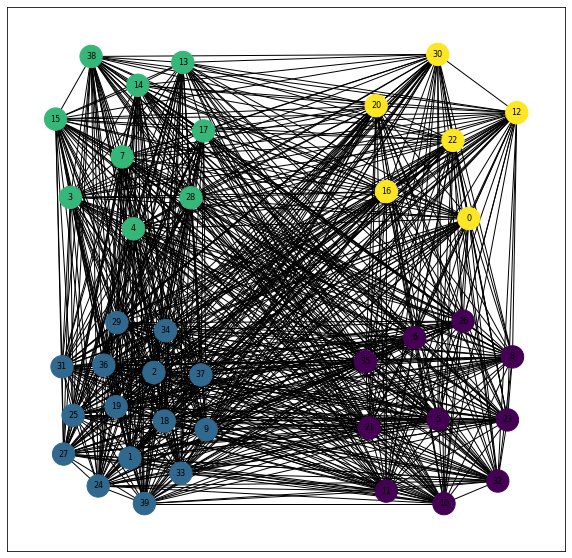

In [53]:
# Create a layout for the graph
pos = create_cluster_layout(G, labels=kmeans.labels_)
# Create a new figure
plt.figure(figsize=(10,10))
# Draw the graph using the layout
nx.draw_networkx(G, pos, node_color=kmeans.labels_, with_labels=True, node_size=500, font_size=8)
plt.savefig("kmeans_clustering_viz.pdf", bbox_inches="tight")
plt.show()

In [57]:
get_cluster_map(labels=kmeans.labels_, label_names=celebData.attr_names)

defaultdict(list,
            {'3': ['5_o_Clock_Shadow',
              'Bushy_Eyebrows',
              'Goatee',
              'Male',
              'Mustache',
              'Sideburns'],
             '1': ['Arched_Eyebrows',
              'Attractive',
              'Blond_Hair',
              'Heavy_Makeup',
              'High_Cheekbones',
              'No_Beard',
              'Oval_Face',
              'Pointy_Nose',
              'Rosy_Cheeks',
              'Smiling',
              'Wavy_Hair',
              'Wearing_Earrings',
              'Wearing_Lipstick',
              'Wearing_Necklace',
              'Young'],
             '2': ['Bags_Under_Eyes',
              'Bald',
              'Big_Nose',
              'Chubby',
              'Double_Chin',
              'Eyeglasses',
              'Gray_Hair',
              'Receding_Hairline',
              'Wearing_Necktie'],
             '0': ['Bangs',
              'Big_Lips',
              'Black_Hair',
              'Blurr

### Stockastic Block Model Visualization